# Projet de Catégorisation de texte (Feature engineering)

### Modules à installer

In [1]:
#!pip install -U textblob
#!pip install -U spacy
#!python -m spacy download en
#!python -m spacy download en_core_web_sm
#ltk.download()
#!python -m textblob.download_corpora
#!pip install gensim
# !pip install mlflow
# !pip install pyngrok

#### Import des modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from textblob import TextBlob
import nltk

from nltk.corpus import stopwords
import nltk

from nltk.stem import PorterStemmer

import os
mypath =''
if os.path.isdir('bbcsport'):
    print('Le répertoire des Datas existe')
    mypath+= 'bbcsport'
else:
    print('Veuillez créer le répertoire des Data à traiter')

mypath = 'bbcsport'

from textblob import Word

import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

import mlflow as mlf

Le répertoire des Datas existe


In [3]:
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
mots_stop = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mornd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mornd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mornd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Processing

In [4]:
list_files = []
list_contents = []
list_cat = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        my_path = os.path.join(path, name)
        list_files.append(name.split('.')[0])
        list_cat.append(path.split('\\')[1])
        
        with open(my_path, 'r') as file:
            content = file.read()
            list_contents.append(content)
    


In [5]:
df = pd.DataFrame({'filename':list_files, 'content': list_contents, 'category': list_cat})

#### Data cleanning

In [6]:
df['content'] = df["content"].map(lambda x: TextBlob(x).words) # Tokenize
df["content"] = df["content"].map(lambda line :  [mot.lower() for mot in line if mot.lower() not in mots_stop] ) # Data lower
df["content"] = df["content"].map(lambda line :  [mot for mot in line if re.match(r'^-?\d+(?:\.\d+)$', mot) is None] )
df["content"] = df["content"].map(lambda line :  [mot for mot in line if re.match(r"^\'\w{2}$", mot) is None] )
df["content"] = df["content"].map(lambda line :  [mot for mot in line if re.match(r"^\'\w$", mot) is None] )
df["content"] = df["content"].map(lambda line :  [mot for mot in line if re.match(r"[^@]+@[^@]+\.[^@]+", mot) is None] )
df["content"] = df["content"].map(lambda line :  [mot for mot in line if re.match(r".*\d+.*", mot) is None] )
df["content"] = df["content"].map(lambda line :  [ps.stem(mot) for mot in line] )
df["content"] = df["content"].map(lambda line :  [Word(mot).lemmatize() for mot in line] )
df["content"] = df["content"].map(lambda line : " ".join([mot for mot in line]))

In [7]:
df

,filename,content,category
0,001,claxton hunt first major medal british hurdler...,athletics
1,002,o'sullivan could run world sonia o'sullivan in...,athletics
2,003,green set sight world titl mauric green aim wi...,athletics
3,004,iaaf launch fight drug iaaf athlet world gover...,athletics
4,005,dibaba break world record ethiopia tirunesh di...,athletics
...,...,...,...
732,096,agassi second round dubai fourth seed andr aga...,tennis
733,097,mauresmo fight back win titl world number two ...,tennis
734,098,feder win titl rotterdam world number one roge...,tennis
735,099,gb player warn secur britain davi cup player w...,tennis


### Data distribution

In [8]:
df['category'].value_counts()

football     265
rugby        147
cricket      124
athletics    101
tennis       100
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

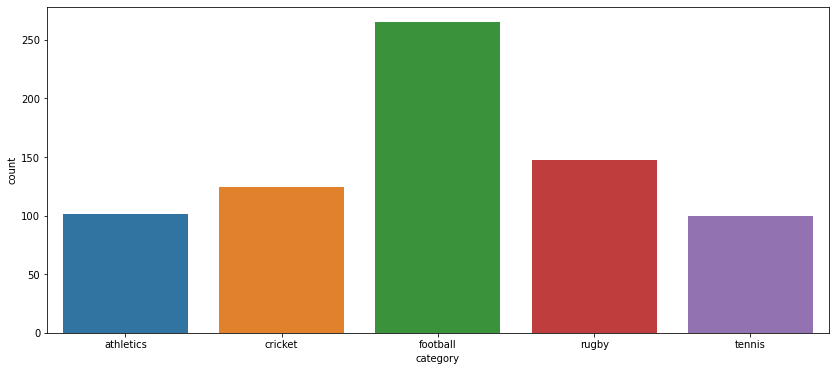

In [9]:
plt.figure(figsize=(14,6))
sns.countplot(x='category', data=df)

#### Remarque: 
   * Nous remarquons une imbalance des données, avec la catégorie football qui est hyper dominant dans la représentation des donées  

### Approach to deal with the imbalanced dataset : Resampling (Oversampling)

In [10]:
from sklearn.utils import resample

In [11]:
val_ru = df[(df['category']=='rugby') ]
val_te = df[(df['category']=='tennis') ]
val_at = df[(df['category']=='athletics') ]
val_cr = df[(df['category']=='cricket') ]

In [12]:
val_foot = df[(df['category']=='football')]

In [13]:
df_minority_upsampled_ru = resample(val_ru,replace=True, n_samples= 265,random_state=42)
df_minority_upsampled_te = resample(val_te,replace=True, n_samples= 265,random_state=42)
df_minority_upsampled_at = resample(val_at,replace=True, n_samples= 265,random_state=42)
df_minority_upsampled_cr = resample(val_cr,replace=True, n_samples= 265,random_state=42)

In [14]:
df_upsampled = pd.concat([df_minority_upsampled_ru, df_minority_upsampled_te, df_minority_upsampled_at, df_minority_upsampled_cr, val_foot])

In [15]:
df_upsampled['category'].value_counts()


rugby        265
tennis       265
athletics    265
cricket      265
football     265
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

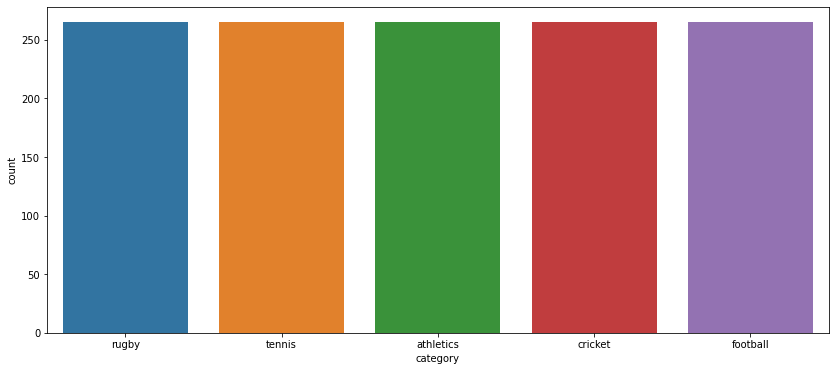

In [16]:
plt.figure(figsize=(14,6))
sns.countplot(x='category', data=df_upsampled)

In [17]:
df = df_upsampled
df

,filename,content,category
592,103,campbel lion consult former govern commun chie...,rugby
582,093,wasp leicest leicest withstood stun wasp comeb...,rugby
504,015,ref stand scotland decis refere saturday franc...,rugby
596,107,dawson set new wasp contract european champion...,rugby
561,072,wale get william fit boost wale hope opensid f...,rugby
...,...,...,...
485,261,crusad ballymena unit ballymena unit came back...,football
486,262,van nistelrooy hungri return manchest unit str...,football
487,263,kean defiant vieira bust-up manchest unit capt...,football
488,264,tartan armi given safeti pledg scotland fan ab...,football


### Data split in Train and Test

In [18]:
X = df['content']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

# Feature engineering with TF-IDF, Bag of word, Word Embedding

## 1. TF-IDF (Term frequency-inverse document frequency)

In [19]:
mlf.set_experiment("Tf_Idf")
mlf.sklearn.autolog()

### Randomn Forest

In [20]:
with mlf.start_run(run_name = 'Random_Forest_tfidf'):
    pipeline_tfidf_rf = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words="english", sublinear_tf=True)),
                     ('rf', RandomForestClassifier())])
    model_tfidf_rf = pipeline_tfidf_rf.fit(X_train, y_train)
    predict_tfidf_rf = model_tfidf_rf.predict(X_test)

In [21]:
print ("Score sur le train: ",model_tfidf_rf.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_tfidf_rf.score(X_test, y_test))

Score sur le train:  1.0
Score sur le test ou Accuracy:  0.9886792452830189


### Decision Tree

In [22]:
with mlf.start_run(run_name = 'Decision_Tree_tfidf'):
    pipeline_tfidf_dt = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 10), stop_words="english", sublinear_tf=True)),
                     ('dt', DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5))])
    model_tfidf_dt = pipeline_tfidf_dt.fit(X_train, y_train)
    predict_tfidf_dt = model_tfidf_dt.predict(X_test)

In [23]:
print ("Score sur le train: ",model_tfidf_dt.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_tfidf_dt.score(X_test, y_test))

Score sur le train:  0.6179245283018868
Score sur le test ou Accuracy:  0.5962264150943396


## 2. Bag of Words

In [24]:
mlf.set_experiment("Bag_of_word")
mlf.sklearn.autolog()

### Randomn Forest

In [25]:
with mlf.start_run(run_name = 'Random_Forest_bow'):
    pipeline_bow_rf = Pipeline([('vect', CountVectorizer()),('rf', RandomForestClassifier(n_jobs=2, random_state=0))])
    model_bow_rf = pipeline_bow_rf.fit(X_train, y_train)
    predict_bow_rf = model_bow_rf.predict(X_test)

In [26]:
print("Score sur le train: ",model_bow_rf.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_bow_rf.score(X_test, y_test))

Score sur le train:  1.0
Score sur le test ou Accuracy:  0.9849056603773585


### Decision Tree

In [27]:
with mlf.start_run(run_name = 'Decision_Tree_bow'):
    pipeline_bow_dt = Pipeline([('vect', CountVectorizer()),
                     ('dt', DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5))])
    model_bow_dt = pipeline_bow_dt.fit(X_train, y_train)
    predict_bow_dt = model_bow_dt.predict(X_test)

In [28]:
print ("Score sur le train: ",model_bow_dt.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_bow_dt.score(X_test, y_test))

Score sur le train:  0.6113207547169811
Score sur le test ou Accuracy:  0.6264150943396226


## 3. Word Embedding

In [29]:
mlf.set_experiment("Word_Embedding")
mlf.sklearn.autolog()

In [30]:
model1 = gensim.models.Word2Vec(list_contents, min_count = 1,vector_size  = 100, window = 5, sg=2) 

In [31]:
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1
word2vec_model_file =  'word2vec_' + str(size) + '.model'

In [32]:
df['content_token'] = df["content"].map(lambda x: TextBlob(x).words)

In [33]:
w2v_model = Word2Vec(df.content_token, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)
w2v_model.save(word2vec_model_file)
sg_w2v_model = Word2Vec.load(word2vec_model_file)


In [34]:
nlp = spacy.load('en_core_web_sm')    

In [35]:
def get_vector(x):
    doc = nlp(x)
    
    return doc.vector

In [36]:
df['vector'] = df['content'].map(lambda line: get_vector(line))

In [37]:
X = df['vector'].to_numpy()
X = X.reshape(-1,1)
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1,96)

In [38]:
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

### Randomn Forest

In [39]:
with mlf.start_run(run_name = 'Random_Forest_we'):
    pipeline_we_rf = Pipeline([('rf', RandomForestClassifier())])
    model_we_rf = pipeline_we_rf.fit(X_train, y_train)
    predict_we_rf = model_we_rf.predict(X_test)

In [40]:
print("Score sur le train: ",model_we_rf.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_we_rf.score(X_test, y_test))

Score sur le train:  1.0
Score sur le test ou Accuracy:  0.9056603773584906


### Decision Tree

In [41]:
with mlf.start_run(run_name = 'Decision_Tree_we'):
    pipeline_we_dt = Pipeline([('dt', DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5))])
    model_we_dt = pipeline_we_dt.fit(X_train, y_train)
    predict_we_dt = model_we_dt.predict(X_test)

In [42]:
print ("Score sur le train: ",model_we_dt.score(X_train, y_train))
print("Score sur le test ou Accuracy: ",model_we_dt.score(X_test, y_test))

Score sur le train:  0.5094339622641509
Score sur le test ou Accuracy:  0.47924528301886793


## Ngrok Server Start

In [43]:
from pyngrok import ngrok
ngrok.kill()

NGROK_AUTH_TOKEN = "2CzwTVhxNUJvXPFPC9eMwEoQNEA_485z36r2Qyrq9v8QcDKpt"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("Mlflow tracking UI : ", ngrok_tunnel.public_url)

Mlflow tracking UI :  https://849e-107-171-213-74.ngrok.io


In [44]:
!mlflow ui

^C
